# Set up environments

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import sys
import os
from google.colab import drive

# Find session type
def find_session_type():
    # windows
    if os.name == 'nt':
        path = '../input/data/'

        import japanize_matplotlib
        sns.set(font="IPAexGothic")

    elif os.name == 'posix':
    # Kaggle
        if 'KAGGLE_DATA_PROXY_TOKEN' in os.environ.keys():
            print('This is kaggle session')
            return 'kaggle'

    # Google Colab
        else:
            print('This is colab session')
            # セッションの残り時間の確認
            !cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 / 60 / 60 "h)"}'
            return 'colab'

# Example usage:
if find_session_type() == 'kaggle':
    print("Running in a Kaggle notebook")
elif find_session_type() == 'colab':
    print("Running in Google Colab")
    drive.mount('/content/drive')
    os.makedirs('/content/logs', exist_ok=True)
    os.makedirs('/content/kaggle/input', exist_ok=True)
    os.makedirs('/content/kaggle/output', exist_ok=True)
    import kagglehub
    kagglehub.login()
else:
    print("Not running in a Kaggle notebook or Google Colab")

# if is_google_colab():
#   byu_locating_bacterial_flagellar_motors_2025_path = kagglehub.competition_download('byu-locating-bacterial-flagellar-motors-2025')

#   print('Data source import complete.')

This is colab session
0.00376632days (0.0903917h)
This is colab session
0.00376748days (0.0904194h)
Running in Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre

In [15]:
# Important settings

DEBUG_MODE = False
EPOCH_SIZE = 50

yolo_pretrained_weights = "yolov8n.pt"
model_name = "yolov8n-d"
model_fol_path = os.path.join("/content/drive/MyDrive/kaggle/BYU-motor-detection/models", model_name)
os.makedirs(model_fol_path, exist_ok=True)

## 1) Library and Dependencies

In [3]:
if find_session_type() == 'kaggle':
    !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
    !pip install --no-index --find-links=./packages ultralytics
    !rm -rf ./packages
elif find_session_type() == 'colab':
    # Unzip archive.tar.gz
    !tar --warning=none -xvf /content/drive/MyDrive/kaggle/input/ultralytics-for-offline-install/archive.tar.gz
    !pip install --no-index --find-links=./packages ultralytics  > /content/logs/pipinstall_log.txt
    !rm -rf ./packages

    # Unzip Dataset folder
    !unzip -q /content/drive/MyDrive/kaggle/input/byu-locating-bacterial-flagellar-motors-2025 -d /content/kaggle/input/byu-locating-bacterial-flagellar-motors-2025  > /content/logs/unzip_log.txt
else:
    !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
    !pip install --no-index --find-links=./packages ultralytics
    !rm -rf ./packages

This is colab session
0.00517049days (0.124092h)
This is colab session
0.00517164days (0.124119h)
./packages/
./packages/pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl
./packages/numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/psutil-6.1.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/nvidia_nvtx_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl
./packages/nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl
./packages/charset_normalizer-3.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl
./packages/torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl
./packages/matplotlib-3.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/tqdm-4.67.1-py3-none-any.whl
./packages/networkx-3.4.2

In [4]:
if find_session_type() == 'colab':
    # !rm -r /content/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/
    # !mv /content/kaggle/input/byu-locating-bacterial-flagellar-motors-2025-downsized/ /content/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/
    !rm -r /content/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/
    !mv /content/kaggle/input/byu-locating-bacterial-flagellar-motors-2025-downsized/ /content/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/

This is colab session
0.0155199days (0.372478h)


In [5]:
# Libraries
import plotly.express as px
from PIL import Image, ImageDraw
import random
import seaborn as sns
from matplotlib.patches import Rectangle
from ultralytics import YOLO
import yaml
import json
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import cv2
import threading
import time
from contextlib import nullcontext
from concurrent.futures import ThreadPoolExecutor
import math

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 1.1) Global Constants and Environment Setup

We define paths, create necessary directories, set up the computing device (GPU if available), and fix random seeds for reproducibility.


In [6]:
# Define global constants for dataset directories
if find_session_type() == 'kaggle':
    ROOT_DIR = '/kaggle/'
elif find_session_type() == 'colab':
    ROOT_DIR = '/content/kaggle/'
else:
    ROOT_DIR = '/kaggle/'
DATA_DIR = os.path.join(ROOT_DIR, 'input/byu-locating-bacterial-flagellar-motors-2025')
TRAIN_CSV = os.path.join(DATA_DIR, 'train_labels.csv')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
OUTPUT_DIR = './'
MODEL_DIR = './models'

# Validate datasource access
assert os.path.exists(TRAIN_CSV), f"Training CSV not found :{TRAIN_CSV}"
assert os.path.exists(TRAIN_DIR), f"Training directory not found :{TRAIN_DIR}"
assert os.path.exists(TEST_DIR), f"Test directory not found :{TEST_DIR}"

# Create output directories if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Set device: Use GPU if available; otherwise, fall back to CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

class GPUProfiler:
    def __init__(self, name):
        self.name = name
        self.start_time = None

    def __enter__(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.start_time = time.time()
        return self

    def __exit__(self, *args):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.time() - self.start_time
        # print(f"[PROFILE] {self.name}: {elapsed:.3f}s")


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if device.startswith('cuda'):
    # Set CUDA optimization flags
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on Ampere GPUs
    torch.backends.cudnn.allow_tf32 = True

    # Print GPU info
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
    print(f"Using GPU: {gpu_name} with {gpu_mem:.2f} GB memory")

    # Get available GPU memory and set batch size accordingly
    free_mem = gpu_mem - torch.cuda.memory_allocated(0) / 1e9
    BATCH_SIZE = max(8, min(32, int(free_mem * 4)))  # 4 images per GB as rough estimate
    print(f"Dynamic batch size set to {BATCH_SIZE} based on {free_mem:.2f}GB free memory")
else:
    print("GPU not available, using CPU")
    BATCH_SIZE = 4  # Reduce batch size for CPU

This is colab session
0.0157684days (0.378442h)
This is colab session
0.0157697days (0.378472h)
Using device: cuda
Using GPU: Tesla T4 with 15.83 GB memory
Dynamic batch size set to 32 based on 15.83GB free memory


# 2) Exploratory Data Analysis

## 2.1) Loading the Dataset

We load the training labels into a pandas DataFrame and print basic information such as the dataset shape, column names, and descriptive statistics.


In [7]:
# Load the training labels CSV into a pandas DataFrame
train_labels = pd.read_csv(TRAIN_CSV)

# Display basic dataset information
print("Training dataset shape:", train_labels.shape)
print("\nColumns in the dataset:")
print(train_labels.columns.tolist())

# Display basic statistics for numerical columns
print("\nBasic statistics:")
display(train_labels.describe())

Training dataset shape: (451, 10)

Columns in the dataset:
['row_id', 'tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2', 'Array shape (axis 0)', 'Array shape (axis 1)', 'Array shape (axis 2)', 'Voxel spacing', 'Number of motors']

Basic statistics:


,row_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors
count,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000
mean,359.246120,167.090909,482.467849,492.215078,354.545455,946.585366,936.248337,15.288027,1.842572
std,208.899389,78.083734,198.643513,214.836890,89.171269,16.501277,13.226588,2.456147,1.758675
min,1.000000,0.000000,59.000000,30.000000,300.000000,924.000000,928.000000,13.100000,1.000000
25%,182.500000,119.000000,333.000000,334.000000,300.000000,928.000000,928.000000,13.100000,1.000000
50%,354.000000,157.000000,491.000000,493.000000,300.000000,959.000000,928.000000,15.600000,1.000000
75%,529.500000,205.500000,633.000000,662.500000,500.000000,960.000000,956.000000,15.600000,2.000000
max,735.000000,466.000000,904.000000,902.000000,500.000000,960.000000,960.000000,19.700000,10.000000


## 2.2) Tomogram and Motor Statistics

We now inspect the unique tomograms in the dataset, and look at the distribution of the number of motors per tomogram.

Additionally, we provide a histogram to visually explore the distribution.



Number of unique tomograms: 362

Distribution of motors per tomogram:
Number of motors
1     313
2      30
3       6
4       9
6       3
10      1
Name: count, dtype: int64


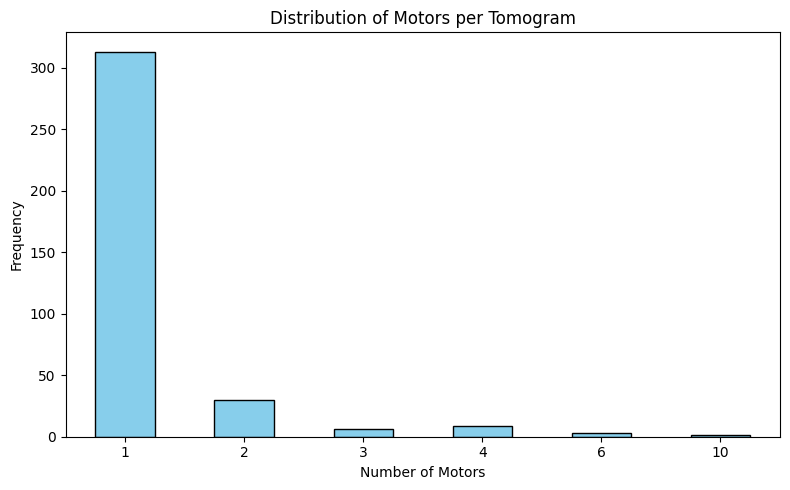

In [8]:
# Count unique tomograms in the dataset
unique_tomo_count = train_labels['tomo_id'].nunique()
print(f"\nNumber of unique tomograms: {unique_tomo_count}")

# Compute distribution of motors per tomogram
motors_per_tomo = train_labels.groupby('tomo_id')['Number of motors'].first().value_counts().sort_index()
print("\nDistribution of motors per tomogram:")
print(motors_per_tomo)

# Visualize the distribution with a bar plot
plt.figure(figsize=(8, 5))
motors_per_tomo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Motors per Tomogram')
plt.xlabel('Number of Motors')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 2.3) Additional Dataset Insights

We take a closer look at:
- A few sample rows from the training labels.
- Missing values per column.
- The range of tomogram sizes (number of slices and image dimensions).
- The distribution of voxel spacing values.


In [9]:
# Display a few sample rows from the training labels
print("\nSample rows from training labels:")
display(train_labels.head())

# Check for missing values in each column
print("\nMissing values per column:")
display(train_labels.isnull().sum())

# Explore the range of tomogram sizes along each axis
print("\nTomogram size ranges:")
print("Z-axis (slices):", train_labels['Array shape (axis 0)'].min(), "to", train_labels['Array shape (axis 0)'].max())
print("X-axis (width):", train_labels['Array shape (axis 1)'].min(), "to", train_labels['Array shape (axis 1)'].max())
print("Y-axis (height):", train_labels['Array shape (axis 2)'].min(), "to", train_labels['Array shape (axis 2)'].max())

# Display voxel spacing distribution
print("\nVoxel spacing distribution:")
voxel_spacing_counts = train_labels['Voxel spacing'].value_counts().sort_index()
display(voxel_spacing_counts)


Sample rows from training labels:


,row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors
0,1,tomo_00e047,169.0,546.0,603.0,300,959,928,15.6,1
1,2,tomo_00e463,235.0,403.0,137.0,500,924,956,19.7,6
2,3,tomo_00e463,243.0,363.0,153.0,500,924,956,19.7,6
3,4,tomo_00e463,222.0,379.0,144.0,500,924,956,19.7,6
4,5,tomo_00e463,225.0,262.0,628.0,500,924,956,19.7,6



Missing values per column:


,0
row_id,0
tomo_id,0
Motor axis 0,0
Motor axis 1,0
Motor axis 2,0
Array shape (axis 0),0
Array shape (axis 1),0
Array shape (axis 2),0
Voxel spacing,0
Number of motors,0



Tomogram size ranges:
Z-axis (slices): 300 to 500
X-axis (width): 924 to 960
Y-axis (height): 928 to 960

Voxel spacing distribution:


,count
Voxel spacing,
13.1,205
13.2,1
15.6,141
16.8,18
19.7,86


In [10]:
# Load the training labels CSV into a pandas DataFrame
train_labels = pd.read_csv(TRAIN_CSV)

# Display basic dataset information
print("Training dataset shape:", train_labels.shape)
print("\nColumns in the dataset:")
print(train_labels.columns.tolist())

# Display basic statistics for numerical columns
print("\nBasic statistics:")
display(train_labels.describe())

Training dataset shape: (451, 10)

Columns in the dataset:
['row_id', 'tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2', 'Array shape (axis 0)', 'Array shape (axis 1)', 'Array shape (axis 2)', 'Voxel spacing', 'Number of motors']

Basic statistics:


,row_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors
count,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000
mean,359.246120,167.090909,482.467849,492.215078,354.545455,946.585366,936.248337,15.288027,1.842572
std,208.899389,78.083734,198.643513,214.836890,89.171269,16.501277,13.226588,2.456147,1.758675
min,1.000000,0.000000,59.000000,30.000000,300.000000,924.000000,928.000000,13.100000,1.000000
25%,182.500000,119.000000,333.000000,334.000000,300.000000,928.000000,928.000000,13.100000,1.000000
50%,354.000000,157.000000,491.000000,493.000000,300.000000,959.000000,928.000000,15.600000,1.000000
75%,529.500000,205.500000,633.000000,662.500000,500.000000,960.000000,956.000000,15.600000,2.000000
max,735.000000,466.000000,904.000000,902.000000,500.000000,960.000000,960.000000,19.700000,10.000000


# 3) **YOLO**

## 3.1) Data Preprocessing for YOLO Dataset Preparation

In this section, we:

- **Load Motor Annotations:** Read the tomogram and motor location annotations.
- **Slice Extraction:** For each motor, extract 2D slices (with a configurable range above and below the motor slice).
- **Image Normalization:** Normalize each slice using percentile-based contrast enhancement.
- **Dataset Organization:** Save the normalized images and generate YOLO-format bounding box annotations.
- **Train/Validation Split:** Split the data by tomogram to avoid any overlap between training and validation sets.
- **Configuration File Generation:** Create a `dataset.yaml` file for YOLO training.


In [16]:
# Define YOLO dataset structure and parameters
if find_session_type() == 'kaggle':
    data_path = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025"
elif find_session_type() == 'colab':
    data_path = "/content/kaggle/input/byu-locating-bacterial-flagellar-motors-2025"
else:
    data_path = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/"
train_dir = os.path.join(data_path, "train")

# Output directories for YOLO dataset (adjust as needed)
# Directries setting
if find_session_type() == 'kaggle':
    WORKING_DIR = "/kaggle/working"
elif find_session_type() == 'colab':
    WORKING_DIR = "/content/kaggle/working"
else:
    WORKING_DIR = "/kaggle/working"

yolo_dataset_dir = os.path.join(WORKING_DIR, "yolo_dataset")
yolo_weights_dir = os.path.join(WORKING_DIR, "yolo_weights")
yolo_images_train = os.path.join(yolo_dataset_dir, "images", "train")
yolo_images_val = os.path.join(yolo_dataset_dir, "images", "val")
yolo_labels_train = os.path.join(yolo_dataset_dir, "labels", "train")
yolo_labels_val = os.path.join(yolo_dataset_dir, "labels", "val")

# Set paths for the preprocessed YOLO training images and labels.
images_train_dir = os.path.join(yolo_dataset_dir, "images", "train")
labels_train_dir = os.path.join(yolo_dataset_dir, "labels", "train")


# Create necessary directories
for dir_path in [yolo_images_train, yolo_images_val, yolo_labels_train, yolo_labels_val]:
    os.makedirs(dir_path, exist_ok=True)

# Define constants for processing
TRUST = 4       # Number of slices above and below center slice (total slices = 2*TRUST + 1)
BOX_SIZE = 24   # Bounding box size (in pixels)
TRAIN_SPLIT = 0.8  # 80% training, 20% validation

# Define a helper function for image normalization using percentile-based contrast enhancement.
def normalize_slice(slice_data):
    """
    Normalize slice data using the 2nd and 98th percentiles.

    Args:
        slice_data (numpy.array): Input image slice.

    Returns:
        np.uint8: Normalized image in the range [0, 255].
    """
    p2 = np.percentile(slice_data, 2)
    p98 = np.percentile(slice_data, 98)
    clipped_data = np.clip(slice_data, p2, p98)
    normalized = 255 * (clipped_data - p2) / (p98 - p2)
    return np.uint8(normalized)

# Define the preprocessing function to extract slices, normalize, and generate YOLO annotations.
def prepare_yolo_dataset(trust=TRUST, train_split=TRAIN_SPLIT):
    """
    Extract slices containing motors and save images with corresponding YOLO annotations.

    Steps:
    - Load the motor labels.
    - Perform a train/validation split by tomogram.
    - For each motor, extract slices in a range (± trust parameter).
    - Normalize each slice and save it.
    - Generate YOLO format bounding box annotations with a fixed box size.
    - Create a YAML configuration file for YOLO training.

    Returns:
        dict: A summary containing dataset statistics and file paths.
    """
    # Load the labels CSV
    labels_df = pd.read_csv(os.path.join(data_path, "train_labels.csv"))

    total_motors = labels_df['Number of motors'].sum()
    print(f"Total number of motors in the dataset: {total_motors}")

    # Consider only tomograms with at least one motor
    tomo_df = labels_df[labels_df['Number of motors'] > 0].copy()
    unique_tomos = tomo_df['tomo_id'].unique()
    print(f"Found {len(unique_tomos)} unique tomograms with motors")

    # Shuffle and split tomograms into train and validation sets
    np.random.shuffle(unique_tomos)
    if DEBUG_MODE:
        unique_tomos = unique_tomos[:100]
    split_idx = int(len(unique_tomos) * train_split)
    train_tomos = unique_tomos[:split_idx]
    val_tomos = unique_tomos[split_idx:]
    print(f"Split: {len(train_tomos)} tomograms for training, {len(val_tomos)} tomograms for validation")

    # Helper function to process a list of tomograms
    def process_tomogram_set(tomogram_ids, images_dir, labels_dir, set_name):
        motor_counts = []
        for tomo_id in tomogram_ids:
            # Get motor annotations for the current tomogram
            tomo_motors = labels_df[labels_df['tomo_id'] == tomo_id]
            for _, motor in tomo_motors.iterrows():
                if pd.isna(motor['Motor axis 0']):
                    continue
                motor_counts.append(
                    (tomo_id,
                     int(motor['Motor axis 0']),
                     int(motor['Motor axis 1']),
                     int(motor['Motor axis 2']),
                     int(motor['Array shape (axis 0)']))
                )

        print(f"Will process approximately {len(motor_counts) * (2 * trust + 1)} slices for {set_name}")
        processed_slices = 0

        # Loop over each motor annotation
        for tomo_id, z_center, y_center, x_center, z_max in tqdm(motor_counts, desc=f"Processing {set_name} motors"):
            z_min = max(0, z_center - trust)
            z_max_bound = min(z_max - 1, z_center + trust)
            for z in range(z_min, z_max_bound + 1):
                # Create the slice filename and source path
                slice_filename = f"slice_{z:04d}.jpg"
                src_path = os.path.join(train_dir, tomo_id, slice_filename)
                if not os.path.exists(src_path):
                    print(f"Warning: {src_path} does not exist, skipping.")
                    continue

                # Load, normalize, and save the image slice
                img = Image.open(src_path)
                img_array = np.array(img)
                normalized_img = normalize_slice(img_array)
                dest_filename = f"{tomo_id}_z{z:04d}_y{y_center:04d}_x{x_center:04d}.jpg"
                dest_path = os.path.join(images_dir, dest_filename)
                Image.fromarray(normalized_img).save(dest_path)

                # Prepare YOLO bounding box annotation (normalized values)
                img_width, img_height = img.size
                x_center_norm = x_center / img_width
                y_center_norm = y_center / img_height
                box_width_norm = BOX_SIZE / img_width
                box_height_norm = BOX_SIZE / img_height
                label_path = os.path.join(labels_dir, dest_filename.replace('.jpg', '.txt'))
                with open(label_path, 'w') as f:
                    f.write(f"0 {x_center_norm} {y_center_norm} {box_width_norm} {box_height_norm}\n")

                processed_slices += 1

        return processed_slices, len(motor_counts)

    # Process training tomograms
    train_slices, train_motors = process_tomogram_set(train_tomos, yolo_images_train, yolo_labels_train, "training")
    # Process validation tomograms
    val_slices, val_motors = process_tomogram_set(val_tomos, yolo_images_val, yolo_labels_val, "validation")

    # Generate YAML configuration for YOLO training
    yaml_content = {
        'path': yolo_dataset_dir,
        'train': 'images/train',
        'val': 'images/val',
        'names': {0: 'motor'}
    }
    with open(os.path.join(yolo_dataset_dir, 'dataset.yaml'), 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)

    print(f"\nProcessing Summary:")
    print(f"- Train set: {len(train_tomos)} tomograms, {train_motors} motors, {train_slices} slices")
    print(f"- Validation set: {len(val_tomos)} tomograms, {val_motors} motors, {val_slices} slices")
    print(f"- Total: {len(train_tomos) + len(val_tomos)} tomograms, {train_motors + val_motors} motors, {train_slices + val_slices} slices")

    return {
        "dataset_dir": yolo_dataset_dir,
        "yaml_path": os.path.join(yolo_dataset_dir, 'dataset.yaml'),
        "train_tomograms": len(train_tomos),
        "val_tomograms": len(val_tomos),
        "train_motors": train_motors,
        "val_motors": val_motors,
        "train_slices": train_slices,
        "val_slices": val_slices
    }

# Run the preprocessing
summary = prepare_yolo_dataset(TRUST)
print(f"\nPreprocessing Complete:")
print(f"- Training data: {summary['train_tomograms']} tomograms, {summary['train_motors']} motors, {summary['train_slices']} slices")
print(f"- Validation data: {summary['val_tomograms']} tomograms, {summary['val_motors']} motors, {summary['val_slices']} slices")
print(f"- Dataset directory: {summary['dataset_dir']}")
print(f"- YAML configuration: {summary['yaml_path']}")
print("\nReady for YOLO training!")

This is colab session
0.0201876days (0.484503h)
This is colab session
0.0201888days (0.484531h)
This is colab session
0.02019days (0.484561h)
This is colab session
0.0201911days (0.484586h)
Total number of motors in the dataset: 831
Found 362 unique tomograms with motors
Split: 289 tomograms for training, 73 tomograms for validation
Will process approximately 3267 slices for training


Processing training motors:   0%|          | 0/363 [00:00<?, ?it/s]

Will process approximately 792 slices for validation


Processing validation motors:   0%|          | 0/88 [00:00<?, ?it/s]


Processing Summary:
- Train set: 289 tomograms, 363 motors, 3262 slices
- Validation set: 73 tomograms, 88 motors, 792 slices
- Total: 362 tomograms, 451 motors, 4054 slices

Preprocessing Complete:
- Training data: 289 tomograms, 363 motors, 3262 slices
- Validation data: 73 tomograms, 88 motors, 792 slices
- Dataset directory: /content/kaggle/working/yolo_dataset
- YAML configuration: /content/kaggle/working/yolo_dataset/dataset.yaml

Ready for YOLO training!


## 3.2) Visualization of Preprocessed Data

In this final section, we validate our preprocessing steps by visualizing random training samples along with their YOLO annotations.
This allows us to inspect the bounding box placements and verify that the data is ready for model training.


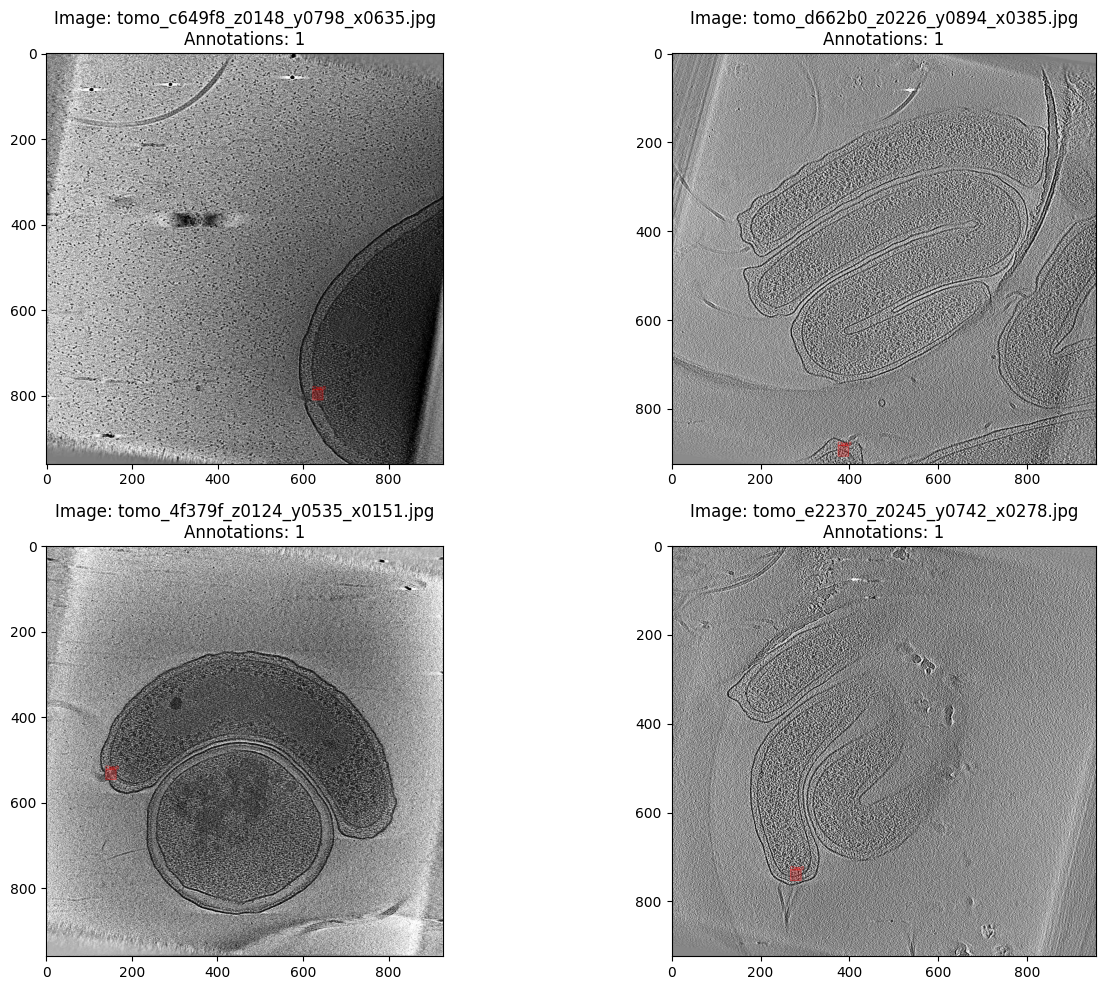

Displayed 4 random images with YOLO annotations


In [17]:
# %%
def visualize_random_training_samples(num_samples=4):
    """
    Visualize random training samples with YOLO annotations.

    Args:
        num_samples (int): Number of random images to display.
    """
    # Get all image files from the train directory (support multiple image extensions)
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_files.extend(glob.glob(os.path.join(yolo_images_train, "**", ext), recursive=True))

    if len(image_files) == 0:
        print("No image files found in the train directory!")
        return

    num_samples = min(num_samples, len(image_files))
    random_images = random.sample(image_files, num_samples)

    # Create subplots for visualization
    rows = int(np.ceil(num_samples / 2))
    cols = min(num_samples, 2)
    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))

    if num_samples == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, img_path in enumerate(random_images):
        try:
            # Determine corresponding label file (YOLO format)
            relative_path = os.path.relpath(img_path, yolo_images_train)
            label_path = os.path.join(yolo_labels_train, os.path.splitext(relative_path)[0] + '.txt')

            # Load and normalize image for display
            img = Image.open(img_path)
            img_width, img_height = img.size
            img_array = np.array(img)
            p2 = np.percentile(img_array, 2)
            p98 = np.percentile(img_array, 98)
            normalized = np.clip(img_array, p2, p98)
            normalized = 255 * (normalized - p2) / (p98 - p2)
            img_normalized = Image.fromarray(np.uint8(normalized))

            # Convert to RGB for annotation drawing
            img_rgb = img_normalized.convert('RGB')
            overlay = Image.new('RGBA', img_rgb.size, (0, 0, 0, 0))
            draw = ImageDraw.Draw(overlay)

            # Load YOLO annotations if available
            annotations = []
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        # YOLO format: class x_center y_center width height (normalized values)
                        values = line.strip().split()
                        class_id = int(values[0])
                        x_center = float(values[1]) * img_width
                        y_center = float(values[2]) * img_height
                        width = float(values[3]) * img_width
                        height = float(values[4]) * img_height
                        annotations.append({
                            'class_id': class_id,
                            'x_center': x_center,
                            'y_center': y_center,
                            'width': width,
                            'height': height
                        })

            # Draw annotations on the overlay
            for ann in annotations:
                x_center = ann['x_center']
                y_center = ann['y_center']
                width = ann['width']
                height = ann['height']
                x1 = max(0, int(x_center - width/2))
                y1 = max(0, int(y_center - height/2))
                x2 = min(img_width, int(x_center + width/2))
                y2 = min(img_height, int(y_center + height/2))
                draw.rectangle([x1, y1, x2, y2], fill=(255, 0, 0, 64), outline=(255, 0, 0, 200))
                draw.text((x1, y1-10), f"Class {ann['class_id']}", fill=(255, 0, 0, 255))

            # Indicate if no annotations were found
            if not annotations:
                draw.text((10, 10), "No annotations found", fill=(255, 0, 0, 255))

            # Composite overlay and display image
            img_rgb = Image.alpha_composite(img_rgb.convert('RGBA'), overlay).convert('RGB')
            axes[i].imshow(np.array(img_rgb))
            img_name = os.path.basename(img_path)
            axes[i].set_title(f"Image: {img_name}\nAnnotations: {len(annotations)}")
            axes[i].axis('on')

        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading image: {os.path.basename(img_path)}",
                         horizontalalignment='center', verticalalignment='center')
            axes[i].axis('off')

    # Turn off any extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Displayed {num_samples} random images with YOLO annotations")

# Run visualization of random training samples
visualize_random_training_samples(4)

##3.3) YOLOv8 Training Pipeline for Flagellar Motor Detection

This notebook implements a full YOLOv8 training pipeline for detecting bacterial flagellar motors in tomographic slices.

Overview:

- Dataset Configuration: Sets up and validates the YOLO-format dataset YAML file.
Model Initialization: Loads pre-trained YOLOv8 weights for transfer learning.
- Training Process: Fine tunes the model with early stopping and periodic checkpoints.
Loss Visualization: Plots training and validation DFL loss curves to monitor progress.
- Performance Evaluation: Tests the trained model on random validation samples.
- Model Export: Saves the trained weights for later use.

Let's begin by importing the necessary libraries and setting up reproducibility.

In [18]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# yolo_pretrained_weights = "/kaggle/input/ultralytics-for-offline-install/yolov8n.pt"  # Pre-downloaded weights

# Create the weights directory if it does not exist
os.makedirs(yolo_weights_dir, exist_ok=True)

## 3.4) Dataset Configuration and YAML Fixing

The function below reads the original YAML file and fixes the paths to match the actual Kaggle directory structure.

- **fix_yaml_paths:** Reads the dataset YAML file, updates the 'path' entry, and writes a fixed version to the working directory.

In [19]:
def fix_yaml_paths(yaml_path):
    """
    Fix the paths in the YAML file to match the actual Kaggle directories.

    Args:
        yaml_path (str): Path to the original dataset YAML file.

    Returns:
        str: Path to the fixed YAML file.
    """
    print(f"Fixing YAML paths in {yaml_path}")
    with open(yaml_path, 'r') as f:
        yaml_data = yaml.safe_load(f)

    if 'path' in yaml_data:
        yaml_data['path'] = yolo_dataset_dir

    fixed_yaml_path = os.path.join(WORKING_DIR, "fixed_dataset.yaml")
    with open(fixed_yaml_path, 'w') as f:
        yaml.dump(yaml_data, f)

    print(f"Created fixed YAML at {fixed_yaml_path} with path: {yaml_data.get('path')}")
    return fixed_yaml_path

## 3.5) Loss Curve Visualization

After training, we want to see how the DFL (Distribution Focal Loss) changes over epochs. The function below reads the `results.csv` file from the training run and plots the training and validation DFL loss curves.

- **plot_dfl_loss_curve:** Reads the results CSV, finds the epoch with the best validation loss, plots both curves, and saves the plot.

In [20]:
def plot_dfl_loss_curve(run_dir):
    """
    Plot the DFL loss curves for training and validation, marking the best model.

    Args:
        run_dir (str): Directory where the training results are stored.
    """
    results_csv = os.path.join(run_dir, 'results.csv')
    if not os.path.exists(results_csv):
        print(f"Results file not found at {results_csv}")
        return

    results_df = pd.read_csv(results_csv)
    train_dfl_col = [col for col in results_df.columns if 'train/dfl_loss' in col]
    val_dfl_col = [col for col in results_df.columns if 'val/dfl_loss' in col]

    if not train_dfl_col or not val_dfl_col:
        print("DFL loss columns not found in results CSV")
        print(f"Available columns: {results_df.columns.tolist()}")
        return

    train_dfl_col = train_dfl_col[0]
    val_dfl_col = val_dfl_col[0]

    best_epoch = results_df[val_dfl_col].idxmin()
    best_val_loss = results_df.loc[best_epoch, val_dfl_col]

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['epoch'], results_df[train_dfl_col], label='Train DFL Loss')
    plt.plot(results_df['epoch'], results_df[val_dfl_col], label='Validation DFL Loss')
    plt.axvline(x=results_df.loc[best_epoch, 'epoch'], color='r', linestyle='--',
                label=f'Best Model (Epoch {int(results_df.loc[best_epoch, "epoch"])}, Val Loss: {best_val_loss:.4f})')
    plt.xlabel('Epoch')
    plt.ylabel('DFL Loss')
    plt.title('Training and Validation DFL Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plot_path = os.path.join(run_dir, 'dfl_loss_curve.png')
    plt.savefig(plot_path)
    plt.savefig(os.path.join(WORKING_DIR, 'dfl_loss_curve.png'))

    print(f"Loss curve saved to {plot_path}")
    plt.close()

    return best_epoch, best_val_loss

In [21]:
def train_yolo_model(yaml_path, pretrained_weights_path, epochs=30, batch_size=16, img_size=640):
    """
    Train a YOLO model on the prepared dataset.

    Args:
        yaml_path (str): Path to the dataset YAML file.
        pretrained_weights_path (str): Path to pre-downloaded weights file.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        img_size (int): Image size for training.
    """
    print(f"Loading pre-trained weights from: {pretrained_weights_path}")
    model = YOLO(pretrained_weights_path)

    results = model.train(
        data=yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        project=yolo_weights_dir,
        name='motor_detector',
        exist_ok=True,
        patience=5,
        save_period=5,
        val=True,
        verbose=True
    )

    run_dir = os.path.join(yolo_weights_dir, 'motor_detector')
    best_epoch_info = plot_dfl_loss_curve(run_dir)
    if best_epoch_info:
        best_epoch, best_val_loss = best_epoch_info
        print(f"\nBest model found at epoch {best_epoch} with validation DFL loss: {best_val_loss:.4f}")

    return model, results

def predict_on_samples(model, num_samples=4):
    """
    Run predictions on random validation samples and display results.

    Args:
        model: Trained YOLO model.
        num_samples (int): Number of random samples to test.
    """
    val_dir = os.path.join(yolo_dataset_dir, 'images', 'val')
    if not os.path.exists(val_dir):
        print(f"Validation directory not found at {val_dir}")
        val_dir = os.path.join(yolo_dataset_dir, 'images', 'train')
        print(f"Using train directory for predictions instead: {val_dir}")

    if not os.path.exists(val_dir):
        print("No images directory found for predictions")
        return

    val_images = os.listdir(val_dir)
    if len(val_images) == 0:
        print("No images found for prediction")
        return

    num_samples = min(num_samples, len(val_images))
    samples = random.sample(val_images, num_samples)

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    for i, img_file in enumerate(samples):
        if i >= len(axes):
            break

        img_path = os.path.join(val_dir, img_file)
        results = model.predict(img_path, conf=0.25)[0]
        img = Image.open(img_path)
        axes[i].imshow(np.array(img), cmap='gray')

        # Draw ground truth box if available (extracted from filename)
        try:
            parts = img_file.split('_')
            y_part = [p for p in parts if p.startswith('y')]
            x_part = [p for p in parts if p.startswith('x')]
            if y_part and x_part:
                y_gt = int(y_part[0][1:])
                x_gt = int(x_part[0][1:].split('.')[0])
                box_size = 24
                rect_gt = Rectangle((x_gt - box_size//2, y_gt - box_size//2), box_size, box_size,
                                      linewidth=1, edgecolor='g', facecolor='none')
                axes[i].add_patch(rect_gt)
        except:
            pass

        if len(results.boxes) > 0:
            boxes = results.boxes.xyxy.cpu().numpy()
            confs = results.boxes.conf.cpu().numpy()
            for box, conf in zip(boxes, confs):
                x1, y1, x2, y2 = box
                rect_pred = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect_pred)
                axes[i].text(x1, y1-5, f'{conf:.2f}', color='red')

        axes[i].set_title(f"Image: {img_file}\nGT (green) vs Pred (red)")

    plt.tight_layout()
    plt.savefig(os.path.join(WORKING_DIR, 'predictions.png'))
    plt.show()

def prepare_dataset():
    """
    Check if the dataset exists and create/fix a proper YAML file for training.

    Returns:
        str: Path to the YAML file to use for training.
    """
    train_images_dir = os.path.join(yolo_dataset_dir, 'images', 'train')
    val_images_dir = os.path.join(yolo_dataset_dir, 'images', 'val')
    train_labels_dir = os.path.join(yolo_dataset_dir, 'labels', 'train')
    val_labels_dir = os.path.join(yolo_dataset_dir, 'labels', 'val')

    print(f"Directory status:")
    print(f"- Train images exists: {os.path.exists(train_images_dir)}")
    print(f"- Val images exists: {os.path.exists(val_images_dir)}")
    print(f"- Train labels exists: {os.path.exists(train_labels_dir)}")
    print(f"- Val labels exists: {os.path.exists(val_labels_dir)}")

    original_yaml_path = os.path.join(yolo_dataset_dir, 'dataset.yaml')
    if os.path.exists(original_yaml_path):
        print(f"Found original dataset.yaml at {original_yaml_path}")
        return fix_yaml_paths(original_yaml_path)
    else:
        print("Original dataset.yaml not found, creating a new one")
        yaml_data = {
            'path': yolo_dataset_dir,
            'train': 'images/train',
            'val': 'images/train' if not os.path.exists(val_images_dir) else 'images/val',
            'names': {0: 'motor'}
        }
        new_yaml_path = os.path.join(WORKING_DIR, 'dataset.yaml')
        with open(new_yaml_path, 'w') as f:
            yaml.dump(yaml_data, f)
        print(f"Created new YAML at {new_yaml_path}")
        return new_yaml_path

## 3.8) Dataset YAML Preparation and Main Training Execution

Before training, we check if the dataset directories exist and either fix or create a new YAML file.

- **prepare_dataset:** Checks for directories and a YAML file, fixes the paths if necessary, or creates a new YAML file.

Finally, the **main** function runs the complete training process and then tests the model on sample images.

In [22]:
def main():
    print("Starting YOLO training process...")
    yaml_path = prepare_dataset()
    print(f"Using YAML file: {yaml_path}")
    with open(yaml_path, 'r') as f:
        print(f"YAML contents:\n{f.read()}")

    print("\nStarting YOLO training...")
    model, results = train_yolo_model(
        yaml_path,
        pretrained_weights_path=yolo_pretrained_weights,
        epochs=EPOCH_SIZE,  # For demonstration, using 30 epochs
        batch_size=BATCH_SIZE
        #TODO: find best epochs.
    )

    print("\nTraining complete!")
    print("\nRunning predictions on sample images...")
    predict_on_samples(model, num_samples=4)

if __name__ == "__main__":
    main()

!cp -r /content/kaggle/working/ $model_fol_path
dataset_fol = os.path.join(model_fol_path, 'yolo_dataset')
!rm -r $dataset_fol

Output hidden; open in https://colab.research.google.com to view.

In [27]:
!rm -r /content/drive/MyDrive/kaggle/BYU-motor-detection/models/yolov8n-d/working/

In [1]:
!cp -r /content/kaggle/working/ $model_fol_path
dataset_fol = os.path.join(model_fol_path, 'yolo_dataset')
!rm -r $dataset_fol

cp: missing destination file operand after '/content/kaggle/working/'
Try 'cp --help' for more information.


NameError: name 'os' is not defined

In [28]:
print()

/content/kaggle/working/yolo_dataset


In [33]:
img_fol = "/content/kaggle/input/byu-locating-bacterial-flagellar-motors-2025"

for dir in os.listdir(os.path.join(img_fol, 'test')):
    if dir.startswith('tomo_'):
        test_img = Image.open(os.path.join(img_fol, 'test', dir, 'slice_0001.jpg'))
        test_img_array = np.array(test_img)
        # Print the property of Image
        print(test_img_array.shape)

for dir in os.listdir(os.path.join(img_fol, 'train')):
    if dir.startswith('tomo_'):
        test_img = Image.open(os.path.join(img_fol, 'train', dir, 'slice_0001.jpg'))
        test_img_array = np.array(test_img)
        # Print the property of Image
        print(test_img_array.shape)

# test_slice = os.path.join("/content/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/test/tomo_00e047/slice_0001.jpg")

# test_img = Image.open(test_slice)
# test_img_array = np.array(test_img)
# # Print the property of Image
# print(test_img_array.shape)

(1912, 1847)
(959, 928)
(960, 928)
(960, 928)
(960, 928)
(928, 928)
(959, 928)
(959, 928)
(959, 928)
(960, 928)
(960, 928)
(960, 928)
(960, 928)
(924, 956)
(959, 928)
(960, 928)
(960, 928)
(928, 960)
(928, 928)
(960, 928)
(960, 928)
(960, 928)
(960, 928)
(928, 928)
(960, 928)
(928, 960)
(928, 928)
(928, 960)
(960, 928)
(960, 928)
(960, 928)
(959, 928)
(960, 928)
(959, 928)
(960, 928)
(960, 928)
(959, 928)
(960, 928)
(959, 928)
(960, 928)
(960, 928)
(960, 928)
(960, 928)
(928, 960)
(960, 928)
(959, 928)
(960, 928)
(928, 928)
(960, 928)
(928, 928)
(960, 928)
(960, 928)
(960, 928)
(960, 928)
(928, 960)
(928, 960)
(959, 928)
(928, 928)
(959, 928)
(960, 928)
(960, 928)
(924, 956)
(928, 960)
(960, 928)
(928, 928)
(928, 928)
(959, 928)
(960, 928)
(959, 928)
(928, 928)
(960, 928)
(960, 928)
(960, 928)
(960, 928)
(924, 956)
(960, 928)
(960, 928)
(960, 928)
(924, 956)
(959, 928)
(960, 928)
(960, 928)
(960, 928)
(959, 928)
(960, 928)
(959, 928)
(924, 956)
(928, 928)
(928, 960)
(960, 928)
(960, 92